Load libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Scaffolds
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Descriptors import MoleculeDescriptors
from scipy import stats
from statsmodels import robust
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
# ... to draw molecules in the notebook
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Read data.

In [162]:
df = pd.read_csv('data/ReadyBiodegradability.csv', header = 0)
df = df.drop(['Unnamed: 0', 'SMILESbeta'], axis=1)
df.sample(5).head()

,SMILES,EndPt,ReadyBiodeg
1128,OC(=O)c1cccnc1,RB,1
1777,CCC1CCCCC1,NRB,0
389,CCOC(=O)c1ccc2c(c1)C(=O)OC2(c1ccc(cc1OCC)N(CC)...,NRB,0
22,OC(=O)\C=C/C(O)=O,RB,1
181,CCCCCCCC\C=C/CCCCCCCCCCCC(N)=O,RB,1


Calculate Murcko frameworks.

In [163]:
for i in range(len(df)):
    df.at[i, 'core'] = MurckoScaffold.MurckoScaffoldSmilesFromSmiles(df.loc[i, 'SMILES'])

In [199]:
df.sample(5).head()

,SMILES,EndPt,ReadyBiodeg,core
1592,CCCCCCCCO,RB,1,
634,N[C@@H](CCC(=O)O)C(=O)O,RB,1,
1867,Oc1c(Cl)cc(Cl)cc1Cl,RB,1,c1ccccc1
539,CC(=NNC(=S)N)C,NRB,0,
407,N#Cc1cc(C)cc(c1/N=N/c1ccc(cc1NS(=O)(=O)C)N(CC)...,NRB,0,c1ccc(N=Nc2ccccc2)cc1


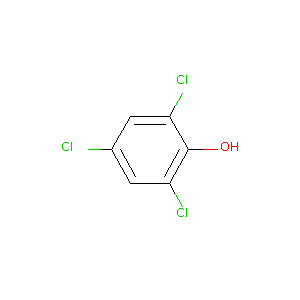

In [202]:
Draw.MolToImage(Chem.MolFromSmiles(df.loc[1867, 'SMILES']))

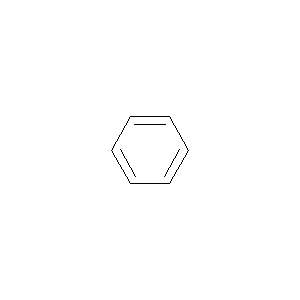

In [203]:
Draw.MolToImage(Chem.MolFromSmiles(df.loc[1867, 'core']))

Examine the *N* most frequent frameworks.

In [168]:
cores_df = pd.DataFrame(cores['core'].value_counts().head(7))

In [169]:
cores_df.reset_index(inplace=True)

In [170]:
cores_df.columns = ['core_SMILES', 'count']

Note that frameworks are not returned for acyclic systems.

In [171]:
cores_df

,core_SMILES,count
0,,666
1,c1ccccc1,512
2,c1ccc2ccccc2c1,43
3,c1ccc(Cc2ccccc2)cc1,36
4,c1ccc(-c2ccccc2)cc1,34
5,c1ccncc1,34
6,c1ccc(N=Nc2ccccc2)cc1,28


Remove the acyclic 'frameworks'.

In [172]:
cores_df = cores_df.iloc[1:]

In [173]:
cores_df = cores_df.reset_index(drop=True)

In [174]:
cores_df

,core_SMILES,count
0,c1ccccc1,512
1,c1ccc2ccccc2c1,43
2,c1ccc(Cc2ccccc2)cc1,36
3,c1ccc(-c2ccccc2)cc1,34
4,c1ccncc1,34
5,c1ccc(N=Nc2ccccc2)cc1,28


Use the SMILES string associated with each framework to build a molecule for that framework.

In [175]:
for i in range(len(cores_df)):
    cores_df.at[i, 'mol'] = Chem.MolFromSmiles(cores_df.loc[i, 'core_SMILES'])

In [176]:
cores_df.head(6)

,core_SMILES,count,mol
0,c1ccccc1,512,<rdkit.Chem.rdchem.Mol object at 0x00000000145...
1,c1ccc2ccccc2c1,43,<rdkit.Chem.rdchem.Mol object at 0x00000000145...
2,c1ccc(Cc2ccccc2)cc1,36,<rdkit.Chem.rdchem.Mol object at 0x00000000147...
3,c1ccc(-c2ccccc2)cc1,34,<rdkit.Chem.rdchem.Mol object at 0x00000000147...
4,c1ccncc1,34,<rdkit.Chem.rdchem.Mol object at 0x00000000147...
5,c1ccc(N=Nc2ccccc2)cc1,28,<rdkit.Chem.rdchem.Mol object at 0x00000000147...


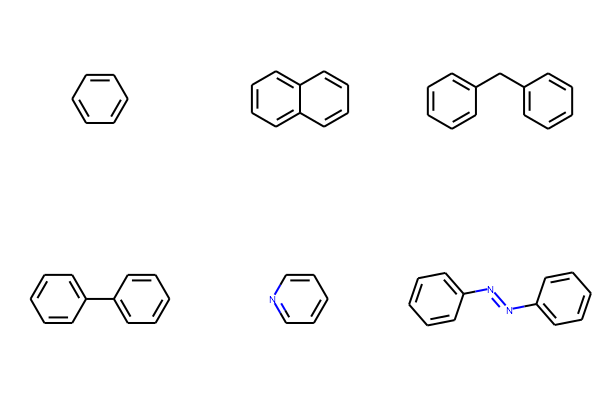

In [205]:
Draw.MolsToGridImage([cores_df.iloc[i, 2] for i in range(len(cores_df))],
                     molsPerRow = 3)

Calculate RDKit descriptors for molecules in the dataset.

In [206]:
nms = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)
for i in range(len(df)):
    try:
        descrs = calc.CalcDescriptors(Chem.MolFromSmiles(df.iloc[i, 0]))
        for x in range(len(descrs)):
            df.at[i, str(nms[x])] = descrs[x]
    except:
        for x in range(len(descrs)):
            df.at[i, str(nms[x])] = 'NaN'   
            
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index(drop=True)

df.sample(5).head()

,SMILES,EndPt,ReadyBiodeg,core,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1384,CCc1ccccc1C=C,NRB,0,c1ccccc1,3.739537,1.085509,3.739537,1.085509,0.580073,132.206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Nc1sccn1,NRB,0,c1cscn1,5.185185,0.634259,5.185185,0.634259,0.521525,100.146,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
116,Clc1ccc(cc1)[S](=O)(=O)c2ccc(Cl)cc2,NRB,0,O=S(=O)(c1ccccc1)c1ccccc1,12.170229,-3.489784,12.170229,0.212243,0.840921,287.167,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1617,CCCCCCCCC=CCCCCCCCCO,RB,1,,8.660967,0.362284,8.660967,0.362284,0.284425,268.485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
1774,CCOC(=O)C(=O)OCC,RB,1,,10.436204,-0.926528,10.436204,0.192111,0.409630,146.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Build training set and test set.

In [5]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42,
                               stratify=df[['ReadyBiodeg']])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [247]:
train['ReadyBiodeg'].value_counts()

0    1043
1     545
Name: ReadyBiodeg, dtype: int64

In [248]:
test['ReadyBiodeg'].value_counts()

0    261
1    136
Name: ReadyBiodeg, dtype: int64

Calculated molecular weight distributions.

(0, 800)

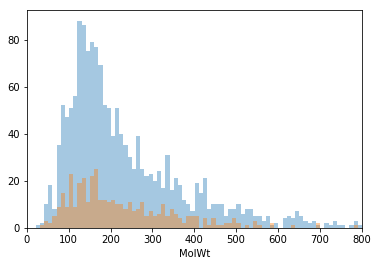

In [230]:
fig, ax = plt.subplots()
for a in [train['MolWt'], test['MolWt']]:
    sns.distplot(a, bins=range(1, 810, 10), ax=ax, kde=False)
ax.set_xlim([0, 800])

Calculated molar refractivity distributions.

(0, 200)

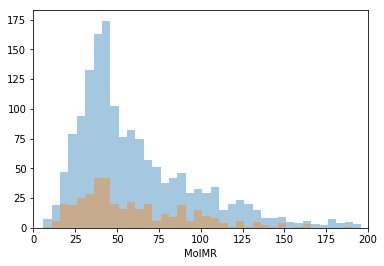

In [236]:
fig, ax = plt.subplots()
for a in [train['MolMR'], test['MolMR']]:
    sns.distplot(a, bins=range(1, 201, 5), ax=ax, kde=False)
ax.set_xlim([0, 200])

Calculated logP distributions.

(-5, 15)

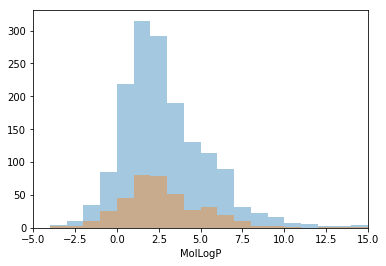

In [239]:
fig, ax = plt.subplots()
for a in [train['MolLogP'], test['MolLogP']]:
    sns.distplot(a, bins=range(-5, 16, 1), ax=ax, kde=False)
ax.set_xlim([-5, 15])

Calculated topological polar surface area distribution.

(0, 250)

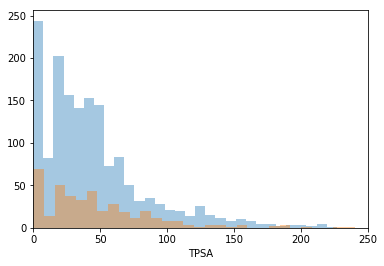

In [246]:
fig, ax = plt.subplots()
for a in [train['TPSA'], test['TPSA']]:
    sns.distplot(a, bins=50, ax=ax, kde=False)
ax.set_xlim([0, 250])

In [7]:
X_train = train.drop(columns=['SMILES', 'SMILESbeta', 'EndPt', 'ReadyBiodeg'])
X_test = test.drop(columns=['SMILES', 'SMILESbeta', 'EndPt', 'ReadyBiodeg'])
y_train = np.ravel(train[['ReadyBiodeg']])
y_test = np.ravel(test[['ReadyBiodeg']])

In [8]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(1588, 200)
(397, 200)
1588
397


Identify near zero variance descriptors.

In [9]:
def variance_threshold_selector(data, threshold = 0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices = True)]]

nzv = variance_threshold_selector(X_train, 0.0)

X_train = X_train[nzv.columns]
X_test = X_test[nzv.columns]

In [10]:
print(X_train.shape)
print(X_test.shape)

(1588, 184)
(397, 184)


Identify highly correlated descriptors.

In [11]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                  k = 1).astype(np.bool))
to_drop = [column for column in upper.columns
           if any(upper[column] > 0.85)]

X_train = X_train[X_train.columns.drop(to_drop)]
X_test = X_test[X_test.columns.drop(to_drop)]

In [12]:
print(X_train.shape)
print(X_test.shape)

(1588, 134)
(397, 134)


Center and scale descriptors.

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

Machine Learning: random forest.

In [14]:
rf = RandomForestClassifier(random_state = 42)

In [15]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Build a search grid.

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [17]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [18]:
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, scoring = 'neg_mean_absolute_error', 
                              cv = 3, verbose = 2, random_state = 42,
                              n_jobs = -1, return_train_score = True)

In [19]:
rf_random.fit(X_train_std, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose

Report the best parameters.

In [20]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 600}

Save the model.

In [21]:
import pickle
f = open('RandomForest.pkl', 'wb')
pickle.dump(rf_random, f)
f.close()

Predict endpoint (ready biodegradability) for compounds in the test set.

In [22]:
pred = rf_random.predict(X_test_std)

In [249]:
pred

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Evaluate model performance, using kappa statistic.

In [23]:
kappa = metrics.cohen_kappa_score(y_test, pred)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.61


Plot ROC curve; calculate the area under the curve (AUC).

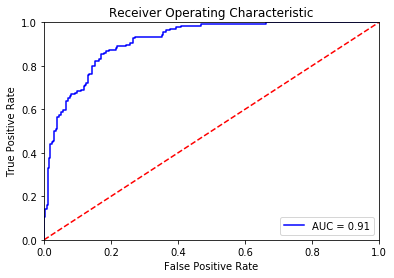

In [24]:
probs = rf_random.predict_proba(X_test_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Print confusion matrix.

In [25]:
print(confusion_matrix(y_test, pred))

[[239  22]
 [ 45  91]]


'Plot' the confusion matrix.

In [27]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

In [28]:
plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds

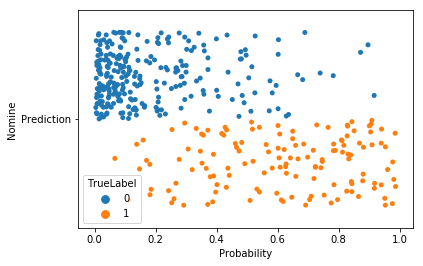

In [29]:
confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', jitter = 0.4, dodge = True, data = plotDF)